In [1]:
from pdesolver import *

# Laplace 1D

Dirichlet Boundary conditions

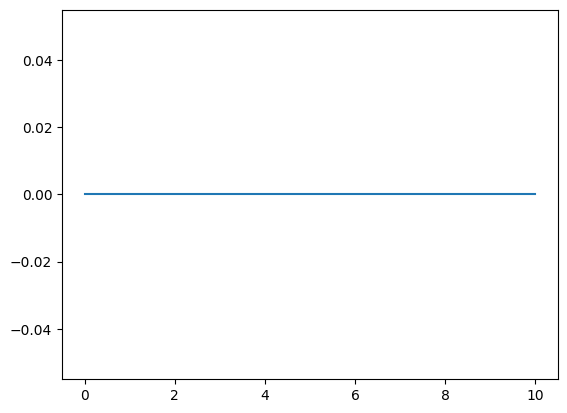

In [2]:
# Define boundary conditions
bcs = AxisBcs(Dirichlet(), Dirichlet()).set() #homogeneous boundary conditions
# alternatively: bcs = boundaryconditions(Dirichlet(), 1)
#define grid
g = Grid(shape=(100,), limits=((0, 10),))
#define equation
eq = Laplace(grid=g, bcs=bcs)
f1 = eq.solve()
f1.plot();

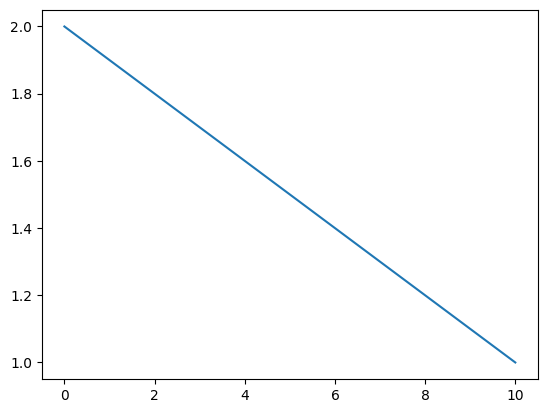

In [3]:
# Define boundary conditions
bcs = AxisBcs(Dirichlet(2), Dirichlet(1)).set() #non homogeneous boundary conditions
#define grid
g = Grid(shape=(100,), limits=((0, 10),))
#define equation
eq = Laplace(grid=g, bcs=bcs)
f = eq.solve()
f.plot();

Neumann boundary conditions

2.0 1.0


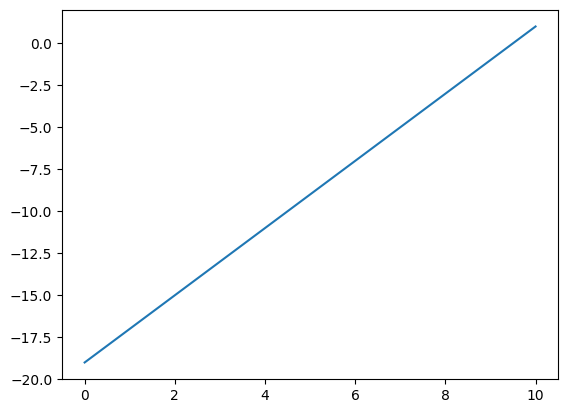

In [4]:
'''
In 1d, if both boundary conditions are neumann left and right, this cannot be solved analytically.
Computationally, the boundary value problem matrix has 0 determinant, and a singular matrix warning is raised.
'''
# Define boundary conditions
bcs = AxisBcs(Neumann(2), Dirichlet(1)).set() #f' = 2 left, f = 1 right
#define grid
g = Grid(shape=(101,), limits=((0, 10),))
#define equation
eq = Laplace(grid=g, bcs=bcs)
f = eq.solve()
f.plot()
# verify boundary conditions are satisfied
print(f.diff().evaluate(0, 0), f.evaluate(0, 10)) # should print 2.0, 1.0

# Time independent Schroedinger with delta potential 1D

$f''(x) + 2\cdot \delta(x)\cdot f(x) = f(x)$

Boundary conditions:
$f'(0^+)-f'(0^-) + 2\cdot f(0) = 0$

Robin coefficients: [2, 1, -1]: These boundary conditions should work, but they don't, and return f(x) = 0, which is also a solution.
Somehow the code should return the non trivial solution.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

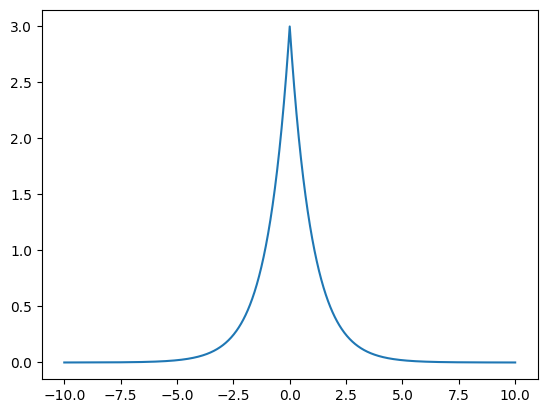

In [5]:
c = Point(0)
bcs = AxisBcs(Dirichlet(), Dirichlet()).set() + Robin([2, 1, -1], c)# these dont work, the solution should be ~ exp(-|x|)
bcs = AxisBcs(Dirichlet(), Dirichlet()).set() + Dirichlet(c, 3) # we can try this instead. the "3" is arbitrary, we can determine it by the normalization constant
'''
So instead of applying the f' discontinuity, we just apply a dirichlet condition
'''
w = Grid((1001,), ((-10, 10),))
T = Diff(2) + Function(lambda x: 0*x-1)
eq = BoundaryValueProblem(w, T, bcs)
eq.solve().plot()

# Poisson 1D

$f''(x) + s(x) = 0$

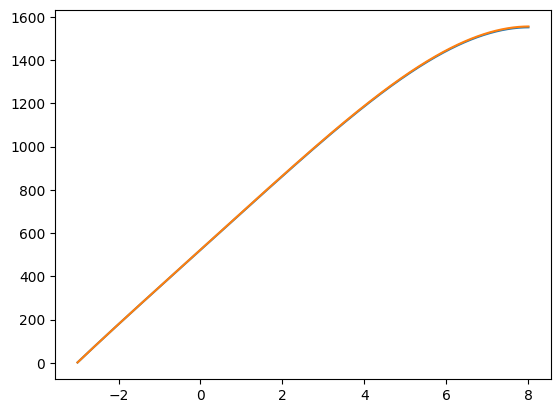

In [6]:
def s(x):
    return x**2

bcs = AxisBcs(Dirichlet(2), Neumann(1)).set()

g = Grid((1000,), ((-3, 8),))
eq = Poisson(g, bcs, s)
f = eq.solve()
f.plot();
plt.plot(g.x[0], 1/12*(6285 + 2060*g.x[0] -g.x[0]**4)); #analytical solution

# Pde of different form

$x^2\cdot f''(x) + x = 0$

operator = r * d^2/dx^2


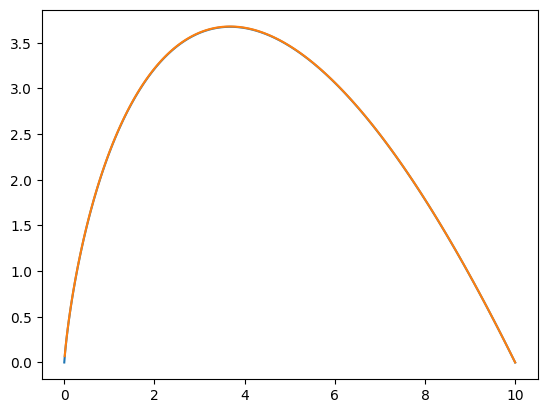

In [7]:
def r(x):
    return x**2

bcs = AxisBcs(Dirichlet(), Dirichlet()).set()
g = Grid((1000,), ((0, 10),))
F = Function(r)
D = Diff(2)
T = F*D #the operator x^2*d^2/dx^2
print('operator =', T.signature)
eq = BoundaryValueProblem(g, T, bcs, source=lambda x: x)
eq.solve().plot()

x = g.x[0][1:]
plt.plot(x, -x*np.log(x/10)); #analytical solution

# Heat equation 1D

$u_t = k\cdot u_{xx} + s(x, t)$

Computing: 99.99 %

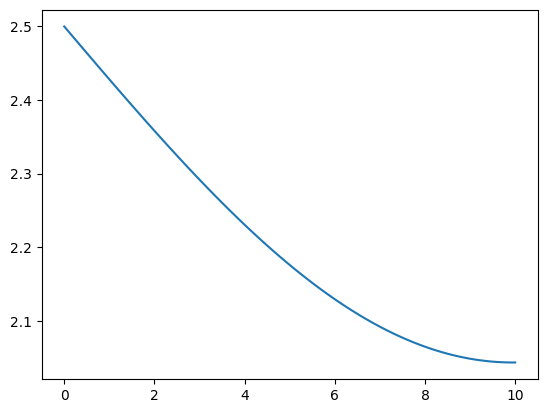

In [8]:
'''
Time dependence is automatically recognized by the 't' parameter
in the python function. This should be the last parameter in the function
e.g f(x, y, z, t) is okay, but f(x, y, t, z) is not okay.
'''

def s(x, t):# the source function
    return np.sin(x-t)

def left(t):#left boundary condition
    if t < 5:
        return t/2
    else:
        return 5/2 + np.exp(-(t-5)/10)*np.sin(t-5)

bcs = AxisBcs(Dirichlet(left), Neumann()).set() #right edge responds freely with a neumann condition

g = Grid((100,), ((0, 10),))
eq = DiffusionEquation(g, bcs, coefficient=1) # k=1 in u_t = k*u_xx

ics = (lambda x: 0*x,) #zero initial conditions.
eq.animate(ics = ics, t=10, dt=0.005, duration=15, fps=30, save='heat1d.mp4');#saves the animation in an mp4 file. If this does not work, try .gif
plt.close() #so that the animation doesnt run in the ipynb file
f = eq.solve(ics[0], 80, 0.005).plot()

# Wave equation 1D

Periodic grid with no boundary conditions

In [9]:
def u(x):
    x_true = np.logical_and(5-np.pi/2<x, x<5+np.pi/2)
    return np.where(x_true, np.sin(x-(5-np.pi/2)), 0)

ics = (u, lambda x: 0*x)# u(x, t=0) and u_t(x, t=0)=0

bcs = AxisBcs().set()#no boundary conditions so that the periodicity of the grid is clear
g = Grid((200,), ((-10, 10),), periodic=(True,))
eq = WaveEquation(g, bcs, 1)
#setting acc=4 below so that it is more accurate. Compare with acc=1
#setting n=1000 in the grid and dt=0.005, with acc=4 produces much more accurate results
eq.animate(ics=ics, t=30, dt=0.01, duration=20, fps=30, acc=4, save='periodic_wave1d.mp4')# If this does not work, try .gif
plt.close()

Computing: 99.97 %

Left edge is bound and right edge free

In [10]:
def left(t):
    #send an initial pulse, and then keep the edge still
    if t<np.pi:
        return np.sin(t)
    else:
        return 0

ics = (lambda x: 0*x, lambda x: 0*x)# u(x, t=0) = u_t(x, t=0)=0
bcs = AxisBcs(Dirichlet(left), Neumann())
g = Grid((1000,), ((-10, 10),))
eq = WaveEquation(g, bcs, 1)
#setting acc=4 below so that it is more accurate. Compare with acc=1
#setting n=1000 in the grid and dt=0.005, with acc=4 produces much more accurate results
eq.animate(ics=ics, t=120, dt=0.005, duration=20, fps=30, acc=4, save='wave1d.mp4')
plt.close()

Computing: 100.0 %

# Laplace 2D

0.7997756955458366 0.8032109509268643


(0.0, 2.0)

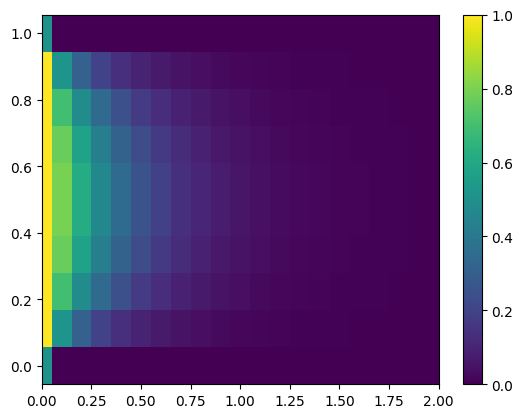

In [11]:


g = Grid((1000, 10), ((0, 100), (0, 1)))

'''
Boundary conditions: f(0, y) = 1, f(inf, y) = 0
                     f(x, 0) = 0, f(x, 1) = 0
This problem is in Griffiths, and is solved analytically there
'''
def f_exact(x, y):
    return  2/np.pi*np.arctan(np.sin(np.pi*y)/np.sinh(np.pi*x))

bcx = AxisBcs(Dirichlet(1), Dirichlet(), axis=0)
bcy = AxisBcs(Dirichlet(0), Dirichlet(), axis=1)
bcs = (bcx+bcy).set()

eq = Laplace(g, bcs)
f = eq.solve()
print(f(0.1, 0.5), f_exact(0.1, 0.5)) #using interpolation, we can approximate the discretized solution
#see how the result changes if we increase the resolution of the grid by 10 each dimension
f.plot()
plt.xlim(0, 2)

Examples done by mr Psolver in his channel

(<Figure size 640x480 with 2 Axes>, <Axes: >)

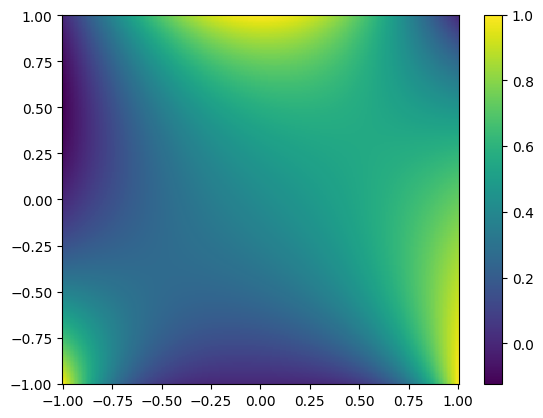

In [12]:

def down(x):
    return x**4

def up(x):
    return np.cos(np.pi*x/2)

def left(y):
    return 0.5 * (y**2-y)

def right(y):
    return 1/(np.e**-1 - np.e) * (np.exp(y) - np.e)


# bc = Dirichlet(Square(0.2, (-0.1, -0.1)), 2)

a = Grid((301, 301), ((-1, 1),(-1, 1)))

bcx = AxisBcs(Dirichlet(left),Dirichlet(right), axis=0)
bcy = AxisBcs(Dirichlet(down),Dirichlet(up), axis=1)

bcs = bcx + bcy

eq = Laplace(a, bcs)

eq.solve().plot()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

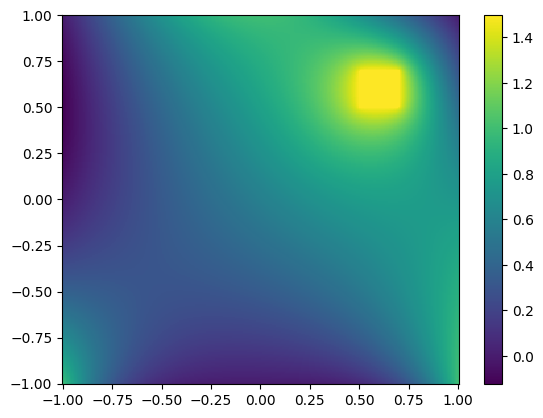

In [13]:
#Now let's add a square with dirichlet boundary conditions
sq = Square(0.2, (0.5, 0.5))
bc_sq = Dirichlet(sq, 1.5)
bcs = bcs.set() + bc_sq #This is how we can add more boundary conditions in problem
eq = Laplace(a, bcs)

eq.solve().plot()

(<Figure size 640x480 with 2 Axes>, <Axes: >)

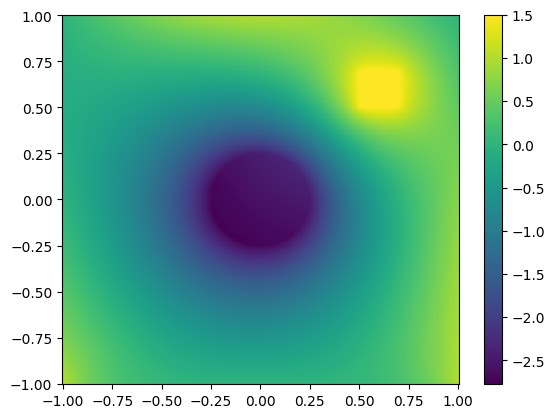

In [14]:
#let's also add a circle with Neumann boundary conditions
c = Circle(0.25, (0, 0))
# Another example: bc_circle = Neumann(c, 10) #df/dn = 2, perpendicularly to the circle
bc_circle = derivative_discontinuity(c, 8)
bcs = bcs + bc_circle #This is how we can add more boundary conditions in problem
eq = Laplace(a, bcs)
f = eq.solve()
f.plot()
#assert that the derivative discontinuity is "8" on the circle indeed:
# for i in range(len(c.nodes(a))):
#     node = c.nodes(a)[i]
#     x = a.coords(node)
#     vec = c.normal_vector(*c.param_values(a)[i])
#     print(f.directional_diff(x=x, direction = vec, fd=1, acc=1)-f.directional_diff(x=x, direction = vec, fd=-1, acc=1))


# Wave equation 2D

#### Oscillating ring in partially periodic grid

In [15]:
g = Grid((601, 601), ((-10, 10), (-10, 10)), periodic=(True, False))
c = Circle(1, (-5,0))
def r(u, t):
    return np.tanh(t)*np.sin(15*(t-u))
def f0(x, y):
    return 0*x

bcx = AxisBcs(axis=0)
bcy = AxisBcs(Dirichlet(), Dirichlet(), axis=1)
bcs = (bcx+bcy).set() + Dirichlet(c, r)
eq = WaveEquation(g, bcs, 1)
ics = (f0, f0)
eq.animate(ics, 10, 0.003, 10, 20, zlims=(0, 1), save='ring.mp4')# If this does not work, try .gif
plt.close('all')


Computing: 99.97 %

#### Oscillating ring in partially periodic grid

In [16]:
g = Grid((601, 601), ((-10, 10), (-10, 10)), periodic=(True, False))
c = Square(2, (1, 0))
def r(u, t):
    return np.sin(15*t)
def f0(x, y):
    return 0*x

bcx = AxisBcs(axis=0)
bcy = AxisBcs(Dirichlet(), Dirichlet(), axis=1)
bcs = (bcx+bcy).set() + Dirichlet(c, r)
eq = WaveEquation(g, bcs, 1)
ics = (f0, f0)
eq.animate(ics, 10, 0.003, 10, 20, zlims=(0, 1), save='square.mp4')# If this does not work, try .gif
plt.close('all')

Computing: 99.97 %